In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
os.makedirs("figs/pdfs", exist_ok=True)
os.makedirs("figs/pngs", exist_ok=True)

In [3]:
# plt.style.use('seaborn')

In [4]:
plt.rcParams['font.size'] = 22
plt.rcParams['axes.grid'] = True
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['savefig.facecolor'] = 'white'
line_alpha = 0.7
shade_alpha = 0.2

In [5]:
csv_path = "outputs/csv/cifar10_main_results.csv"
data = pd.read_csv(csv_path)
# data = np.array(data)

In [6]:
COLORS = {
    'RigL': 'purple',
    'SNFS': 'red',
    'SET': 'blue',
    'Static': 'green',
    'Pruning': 'brown',
    'Dense': 'black',
}

In [7]:
style = {
    'ERK': '-',
    'Random': '-'
}

In [8]:
inits = ['ERK', 'Random']
methods = list(COLORS.keys())

In [9]:
dat = data.loc[data['Method'] == 'Pruning']

In [10]:
list(dat['Init'])[0] is np.nan

True

In [11]:
def plot_runs(data, method, init, **plot_kwargs):
    """Plot accuracies for a single method + init combination."""

    dat = data.loc[data['Method'] == method]

    if method == 'Dense':
        mean = np.array(dat['Mean Acc'])[0]
        stddev = np.array(dat['Std. Dev'])[0]
        line = plt.axhline(mean,
                           alpha=line_alpha,
                           **plot_kwargs,)
        plt.axhspan(mean-stddev, mean+stddev,
                    color=line.get_color(),
                    alpha=shade_alpha,)
        return line

    if not list(dat['Init'])[0] is np.nan:
        dat = dat.loc[dat['Init'] == init]

    x = dat['Density']
    mean = dat['Mean Acc']
    stddev = dat['Std. Dev']

    line, = plt.plot(x, mean,
                     style[init],
                     alpha=line_alpha,
                     **plot_kwargs,)

    plt.fill_between(x, mean-stddev, mean+stddev,
                     facecolor=line.get_color(),
                     alpha=shade_alpha)

    return line

In [12]:
ylimits = (0.89, 0.94)

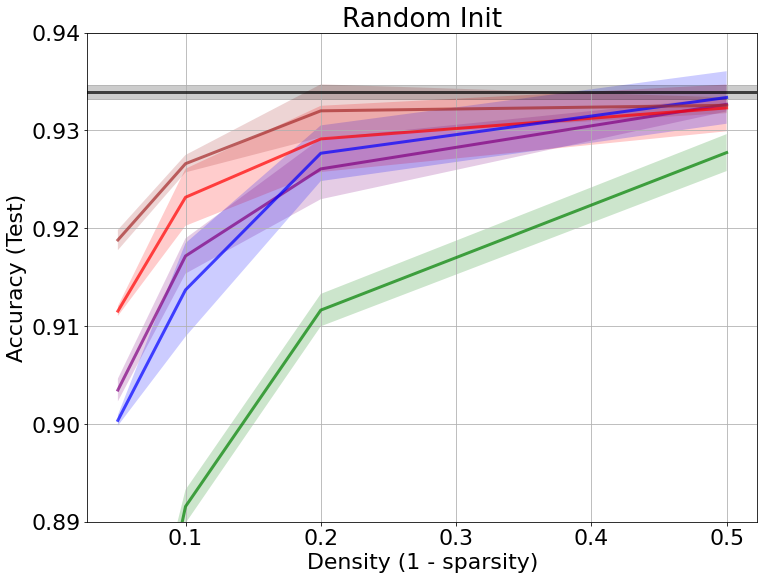

In [13]:
plt.figure(figsize=(12, 9))
for i, method in enumerate(methods):
    a = plot_runs(data, method, init='Random', color=COLORS[method])

plt.ylim(ylimits)
plt.xlabel("Density (1 - sparsity)")
plt.ylabel("Accuracy (Test)")
plt.title("Random Init")

plt.savefig("figs/pdfs/cifar10_random.pdf", bbox_inches='tight')
plt.savefig("figs/pngs/cifar10_random.png", bbox_inches='tight')


plt.show()

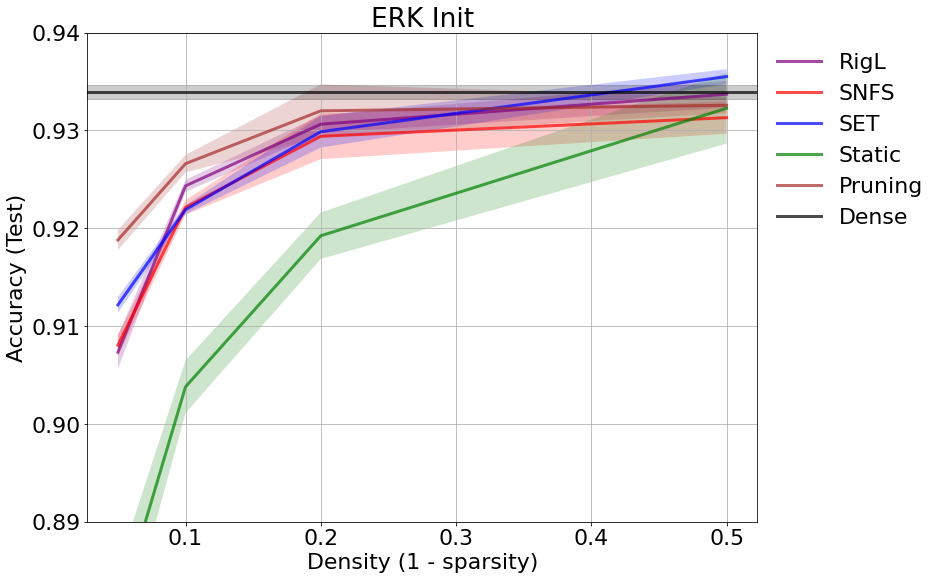

In [14]:
plt.figure(figsize=(12, 9))
for i, method in enumerate(methods):
    plot_runs(data, method, init='ERK', color=COLORS[method])

plt.ylim(ylimits)
plt.xlabel("Density (1 - sparsity)")
plt.ylabel("Accuracy (Test)")
plt.title("ERK Init")
plt.legend(methods, bbox_to_anchor=(1, 1), loc="upper left", frameon=False)

plt.savefig("figs/pdfs/cifar10_ERK.pdf", bbox_inches='tight')
plt.savefig("figs/pngs/cifar10_ERK.png", bbox_inches='tight')

plt.show()

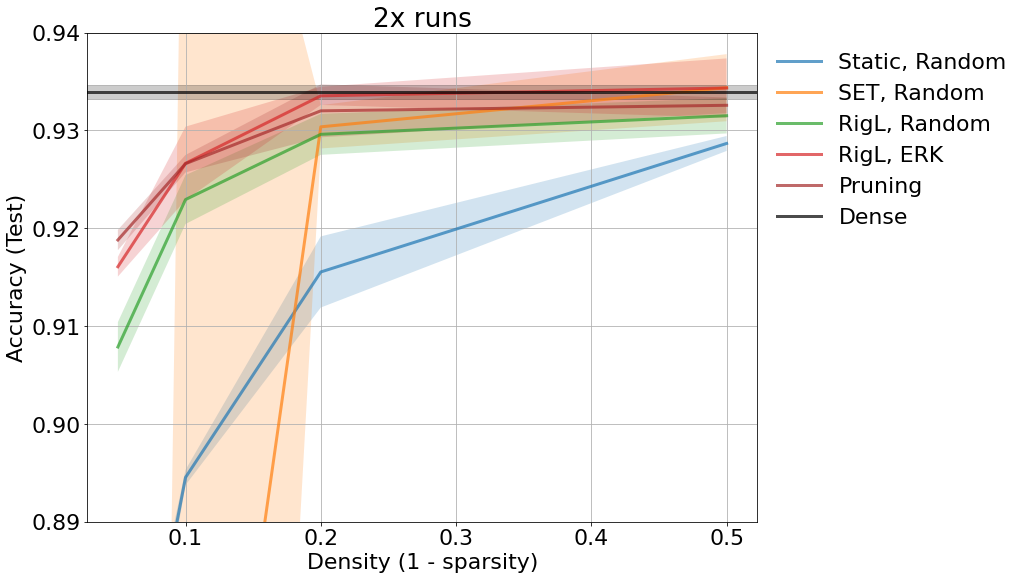

In [15]:
# Need to separately set colors for this one because RigL has multiple plots

plt.figure(figsize=(12, 9))

init = 'Random'
for i, method in enumerate(['Static', 'SET', 'RigL']):
    plot_runs(data, f"{method}_2x", init=init, label=f"{method}, {init}")

init = 'ERK'
method = 'RigL'
plot_runs(data, f"{method}_2x", init=init, label=f"{method}, {init}")


for method in ["Pruning", "Dense"]:
    plot_runs(data, method, init="Random", label=method, color=COLORS[method])


plt.ylim(ylimits)
plt.xlabel("Density (1 - sparsity)")
plt.ylabel("Accuracy (Test)")
plt.title("2x runs")
plt.legend(bbox_to_anchor=(1, 1), loc="upper left", frameon=False)


plt.savefig("figs/pdfs/cifar10_2x.pdf", bbox_inches='tight')
plt.savefig("figs/pngs/cifar10_2x.png", bbox_inches='tight')
plt.show()

In [16]:
# plt.subplots(1, 2, figsize=(20, 8))
# plt.subplot(1, 2, 1)
# lines = {}
# for init in inits:
#     for i, method in enumerate(methods):
#         dat = data.loc[(data['Method'] == method) & (data['Init'] == init)]
#         lines[init], = plt.plot(dat['Density'], dat['Mean Acc'],
#                                 style[init],
#                                 color=COLORS[method],)

# dat = data.loc[(data['Method'] == 'Pruning')]
# plt.plot(dat['Density'], dat['Mean Acc'], color=COLORS['Pruning'])

# plt.ylim(0.88, 0.94)
# plt.xlabel("Density (1 - sparsity)")
# plt.ylabel("Accuracy (Test)")

# plt.subplot(1, 2, 2)
# for init in inits:
#     for i, method in enumerate(methods):
#         dat = data.loc[(data['Method'] == method+'_2x')
#                        & (data['Init'] == init)]
#         plt.plot(dat['Density'], dat['Mean Acc'],
#                  style[init],
#                  color=COLORS[method],
#                  label=method if init == 'Random' else None)

# dat = data.loc[(data['Method'] == 'Pruning')]
# plt.plot(dat['Density'], dat['Mean Acc'],
#          color=COLORS['Pruning'], label='Pruning')
# plt.ylim(0.88, 0.94)
# plt.xlabel("Density (1 - sparsity)")
# plt.ylabel("Accuracy (Test)")
# plt.title("2x runs")


# methods_leg = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
# plt.gca().add_artist(methods_leg)
# plt.legend(handles=lines.values(), labels=lines.keys(),
#            loc='upper left', bbox_to_anchor=(1.02, 0.5))
# # legend(bbox_to_anchor=(1.05, 1), loc='center left')

# plt.tight_layout()
# plt.savefig("figs/cifar10_main.png", bbox_inches='tight')
# plt.show()